# Imports

In [73]:
import pandas as pd
import numpy as np

import vectorbt as vbt
import ast
import empyrical as ep
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import itertools

import warnings
warnings.filterwarnings('ignore')

from utils import *

# Load Data

In [2]:
universe = pd.read_csv('COINGECKO_BINANCE_MAPPING.csv')

In [3]:
ohlcv = pd.read_parquet('binance_futures_ohlcv.parquet')
ohlcv = ohlcv[ohlcv.symbol.isin(universe.binance_perp)]
ohlcv.index = pd.to_datetime(ohlcv.index, utc=True)
ohlcv.reset_index(inplace=True)

price = ohlcv.set_index(['Open time', 'symbol']).unstack('symbol').Close
price.columns.name = None

volume = ohlcv.set_index(['Open time', 'symbol']).unstack('symbol').Volume
volume.columns.name = None

tm_data = pd.read_parquet('../TM_COMBINED_CHART.parquet')
tm_data = tm_data[tm_data.token_id.isin(universe.id)]
tm_data = pd.merge(universe[['id', 'binance_perp']], tm_data, left_on='id', right_on='token_id', how='inner')

mcap = tm_data.set_index(['date', 'binance_perp']).unstack('binance_perp').market_cap
mcap.columns.name = None
mcap.index = pd.to_datetime(mcap.index, utc=True)
mcap = mcap.loc[price.index]

tm_data = None

# Factor Definition

In [47]:
factor = price.pct_change(30)

In [ ]:
# factor_data = pd.read_parquet("./data/futures_global_account_long_short_ratio_binance_1d.parquet")
# factor_data = factor_data.set_index(['date', 'symbol']).unstack('symbol').global_account_long_short_ratio.astype(float)

# # Common Columns and Index
# common_columns = factor_data.columns.intersection(price.columns)
# common_index = factor_data.index.intersection(price.index)

# price = price[common_columns].loc[common_index]
# volume = volume[common_columns].loc[common_index]
# mcap = mcap[common_columns].loc[common_index]
# factor_data = factor_data[common_columns].loc[common_index]

# Initial Simulations

### Simple, Single Backtest

<Axes: xlabel='Open time'>

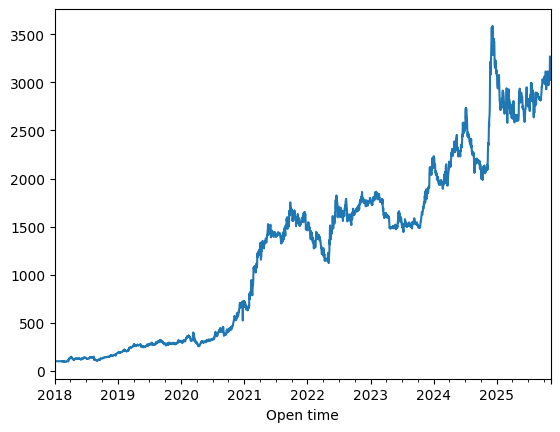

In [70]:
# Align factor and price data
_price = price.copy()
common_index = factor.index.intersection(_price.index)
factor = factor.loc[common_index].copy()
_price = _price.loc[common_index].copy()
_volume = volume.loc[common_index].copy()
_mcap = mcap.loc[common_index].copy()

pfo, weights, trades = get_factor_ls_portfolio(
                            # _price.loc[:'2024-01-01'], 
                            # factor.loc[:'2024-01-01'],
                            # _price.loc['2024-01-01':], 
                            # factor.loc['2024-01-01':], 
                            _price.loc[:], 
                            factor.loc[:],
                            flipped=False, 
                            bt_start=None, 
                            bt_end=None, 
                            fees=0.0005, 
                            visualize_legs=False,
                            volume=None,
                            volume_threshold=None,
                            weight_method="inverse_factor",
                            vol_lookback=30,
                            mcap=_mcap,
                            top=20
                        )

pfo.value().plot()


### Parameter Range Definition

In [1190]:
lookbacks = [1, 3, 7, 14, 30, 60, 90]

### Run all permutations

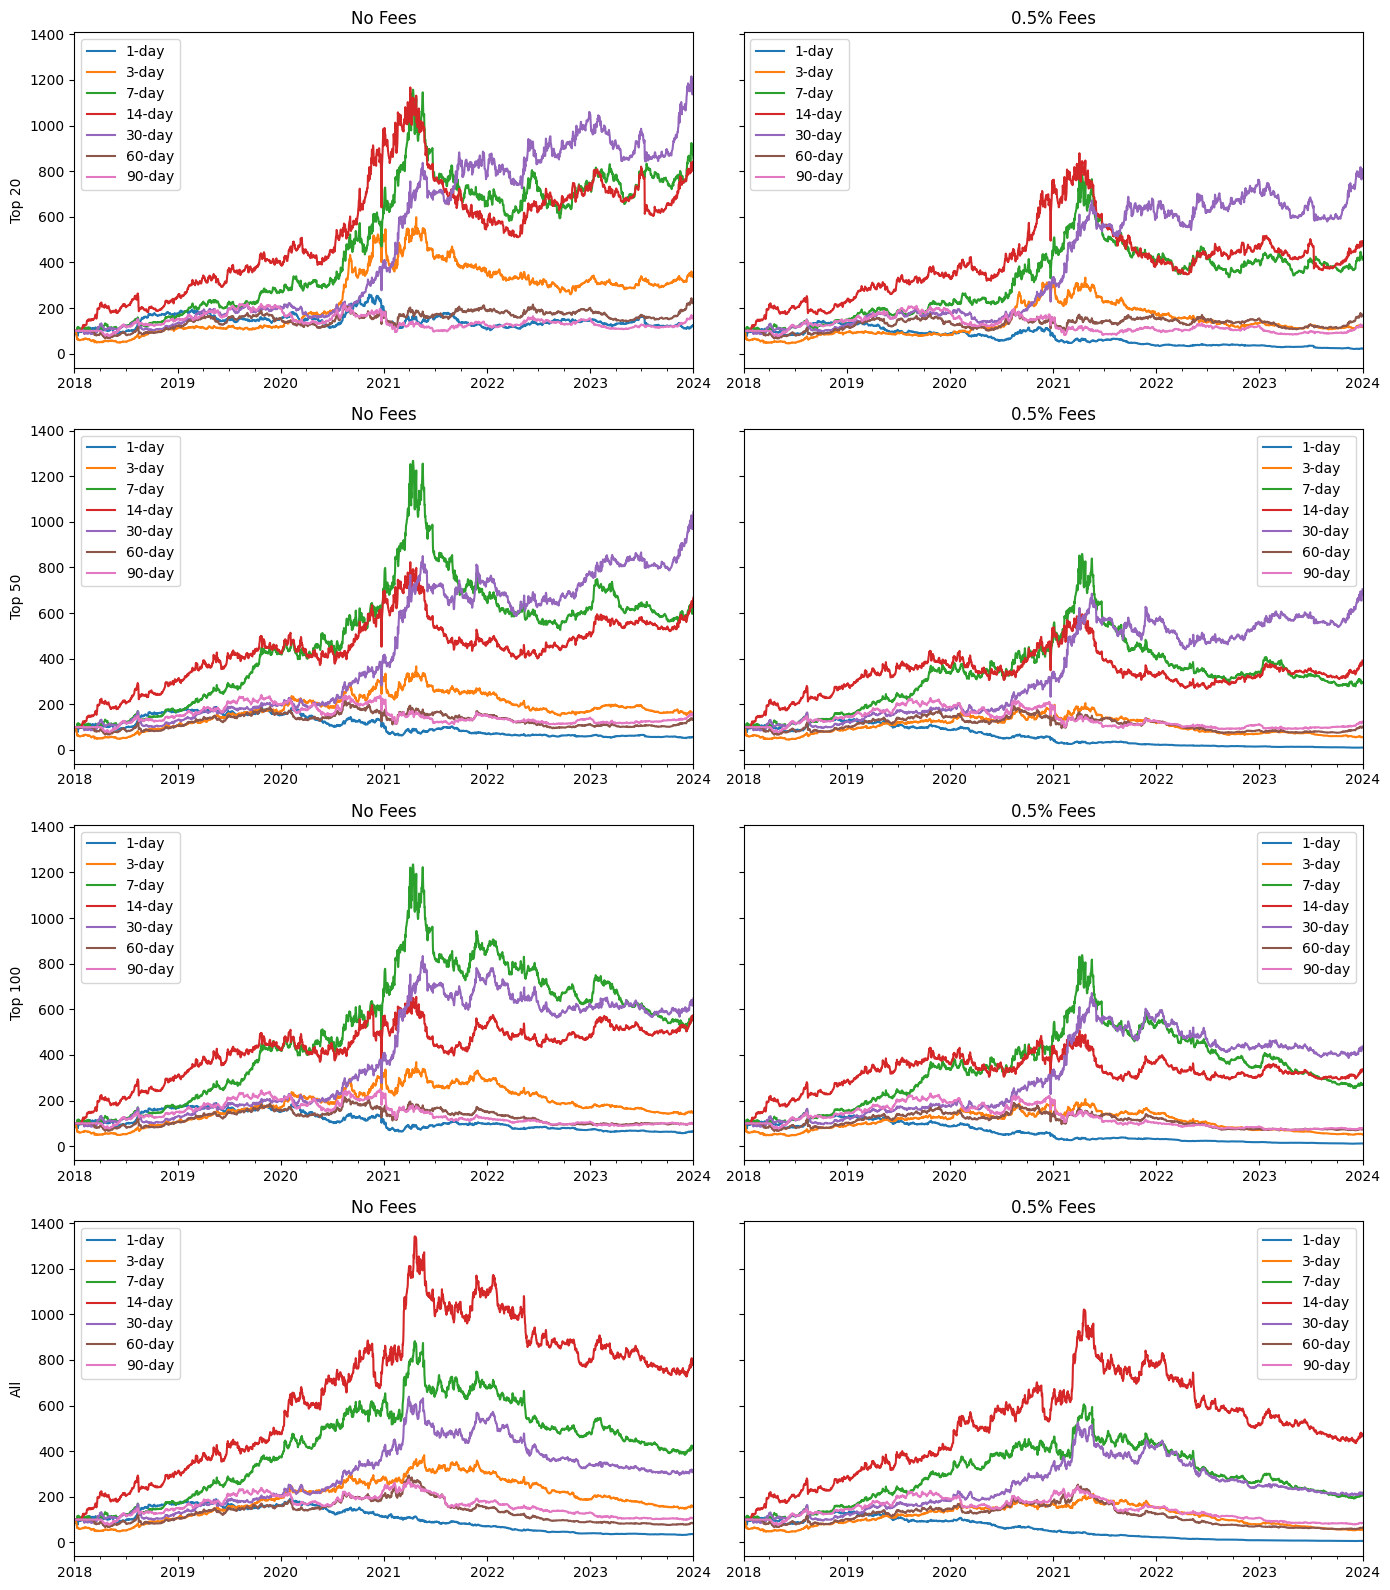

In [1191]:
import matplotlib.pyplot as plt

lookbacks = daily_lookbacks
cohorts = [20, 50, 100, None]
cohort_labels = ["Top 20", "Top 50", "Top 100", "All"]
fee_settings = [0.0, 0.0005]
fee_titles = ["No Fees", "0.5% Fees"]

fig, axes = plt.subplots(len(cohorts), 2, figsize=(14, 4 * len(cohorts)), sharey=True)

rets, turnover = {}, {}
for row, (cohort, cohort_label) in enumerate(zip(cohorts, cohort_labels)):
    for col, (fees, fee_title) in enumerate(zip(fee_settings, fee_titles)):
        for lb in lookbacks:
            # Use consistent price/volume/mcap variable names
            _price = price.copy()
            factor = _price.pct_change(lb)
            common_index = factor.index.intersection(_price.index)
            factor = factor.loc[common_index].copy()
            _price = _price.loc[common_index].copy()
            _volume = volume.loc[common_index].copy()
            _mcap = mcap.loc[common_index].copy()

            _mcap_for_call = _mcap if cohort is not None else None
            _top_for_call = cohort if cohort is not None else None

            pfo, weights, trades = get_factor_ls_portfolio(
                _price.loc[:'2024-01-01'], 
                factor.loc[:'2024-01-01'], 
                flipped=False, 
                bt_start=None, 
                bt_end=None, 
                fees=fees, 
                visualize_legs=False,
                volume=None,
                volume_threshold=None,
                weight_method="equal",
                vol_lookback=None,
                mcap=_mcap_for_call,
                top=_top_for_call
            )

            pfo.value().plot(ax=axes[row, col], label=f'{lb}-day')
            rets[f"{cohort_label}_{fee_title}_{lb}"] = pfo.returns()
            turnover[f"{cohort_label}_{fee_title}_{lb}"] = round(weights.diff().abs().sum(axis=1).mean() * 100, 1)

        axes[row, col].set_title(f"{fee_title}")
        axes[row, col].set_ylabel(f"{cohort_label}")

        # Only show legend on first row or first col, or always if many lines
        axes[row, col].legend()
        axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

In [1193]:
rets = pd.DataFrame(rets)

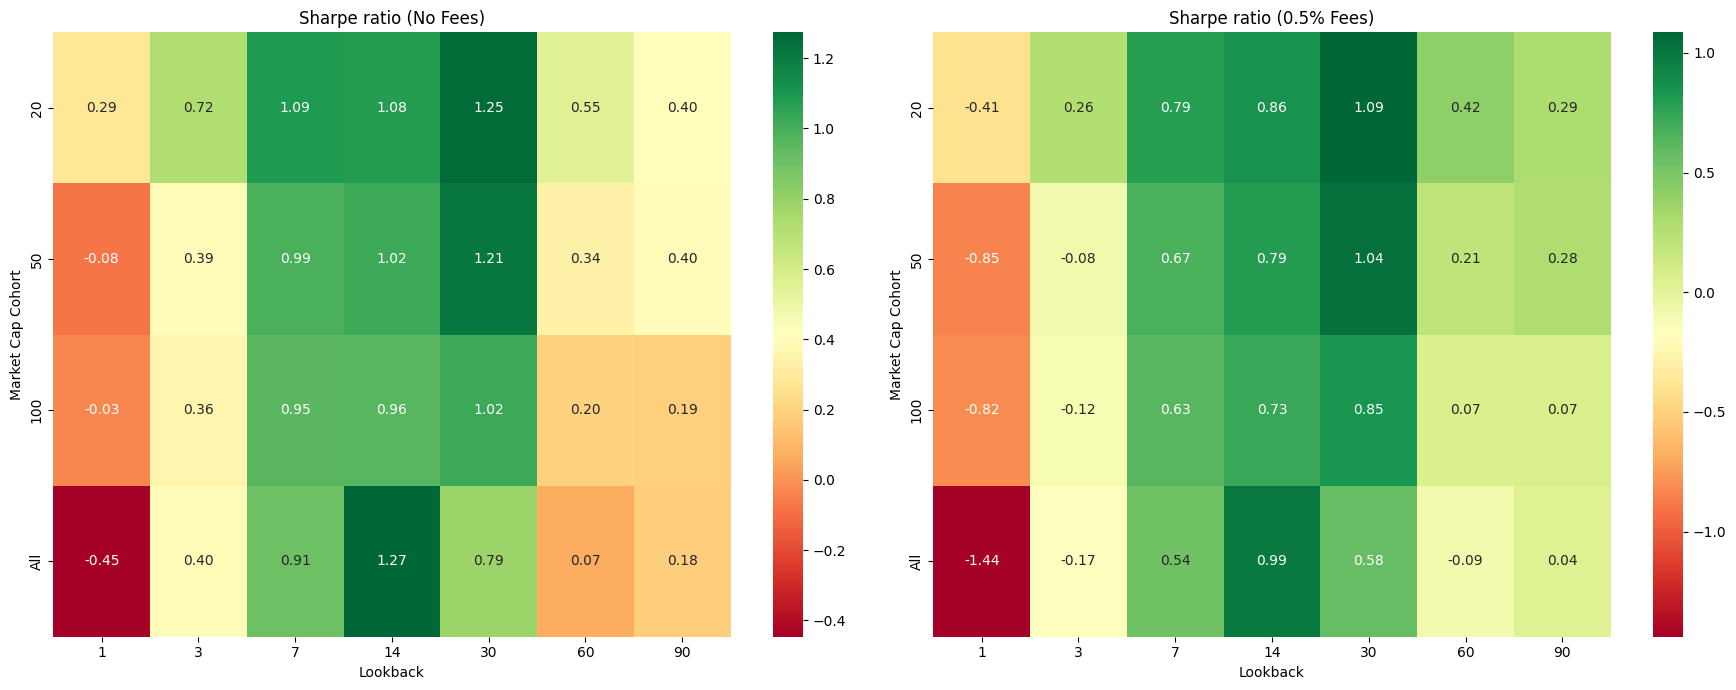

In [1194]:
import seaborn as sns
import matplotlib.pyplot as plt

no_fees_cols = [x for x in rets.columns if 'No Fees' in x]
fees_cols = [x for x in rets.columns if 'No Fees' not in x]

# Get Heatmap grid for Sharpe per parameter × cohort
sr_no_fees = rets[no_fees_cols].apply(ep.sharpe_ratio, annualization=365)
sr_fees = rets[fees_cols].apply(ep.sharpe_ratio, annualization=365)


# Attempt to reshape into heatmap-formatted DataFrames
import re

def parse_label(label):
    # Example label: 'Top 20_No Fees_30' or 'Top 20_0.5% Fees_30'
    m = re.match(r'(.*?)_(.*?)_(\d+)', label)
    if m:
        cohort_label, fee_label, lb = m.groups()
        try:
            cohort_num = int(re.search(r'\d+', cohort_label).group())
        except:
            cohort_num = cohort_label
        try:
            lb = int(lb)
        except:
            pass
        return cohort_num, lb
    return label, None

def sr_to_df(sr, labels):
    rows = []
    for label, val in zip(labels, sr.values):
        cohort, lb = parse_label(label)
        rows.append([cohort, lb, val])
    df = pd.DataFrame(rows, columns=["Market Cap Cohort", "Lookback", "Sharpe"])
    heatmap_df = df.pivot(index="Market Cap Cohort", columns="Lookback", values="Sharpe")
    return heatmap_df

sr_no_fees_hm = sr_to_df(sr_no_fees, sr_no_fees.index)
sr_fees_hm = sr_to_df(sr_fees, sr_fees.index)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# Use a red-to-green colormap; for matplotlib/seaborn, 'RdYlGn' is a good option.
sns.heatmap(sr_no_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[0])
axes[0].set_title("Sharpe ratio (No Fees)")
sns.heatmap(sr_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[1])
axes[1].set_title("Sharpe ratio (0.5% Fees)")
plt.tight_layout()
plt.show()


In [971]:
turnover = pd.Series(turnover).loc[no_fees_cols]
turnover.index = [f"{x.split('_')[0]}_{x.split('_')[2]}d" for x in turnover.index]
turnover = turnover.to_frame().reset_index()
turnover.columns = ['permutation', 'turnover [%]']

In [972]:
# Split the "permutation" column into "market_cap_cohort" and "lookback"
turnover[['market_cap_cohort', 'lookback']] = turnover['permutation'].str.split('_', expand=True)

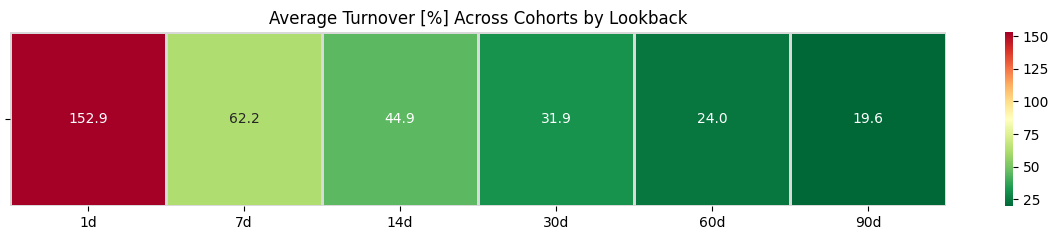

In [974]:
# Pivot table: index=market_cap_cohort, columns=lookback, values=turnover [%]
turnover_heatmap = turnover.pivot(index='market_cap_cohort', columns='lookback', values='turnover [%]')
# Select and order only the columns you want
cols = ['1d', '7d', '14d', '30d', '60d', '90d']
turnover_heatmap = turnover_heatmap[cols]

# Compute the mean across cohorts for each lookback, result is a 1-row DataFrame
avg_row = turnover_heatmap.mean(axis=0).to_frame().T
avg_row.index = ['']  # name the row

plt.figure(figsize=(12, 2.5))
sns.heatmap(
    avg_row,
    annot=True, fmt=".1f", cmap="RdYlGn_r",
    cbar=True, linewidths=1, linecolor='0.85'
)
plt.title(f"Average Turnover [%] Across Cohorts by Lookback")
plt.gca().set_ylabel(None)  # Remove y label
plt.xlabel("")
plt.tight_layout()
plt.show()

# Parameter Sensitivity Analysis

Lb Sweep: 100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


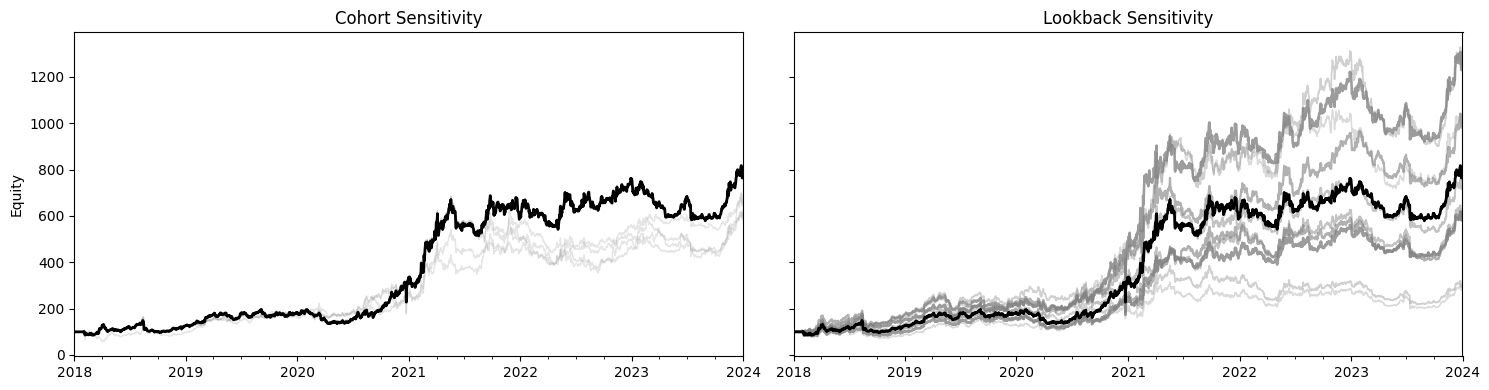

In [1035]:
import matplotlib.pyplot as plt
import numpy as np

selected_permutation = {
    'lb': 30,
    'cohort': 20
}

lookbacks = range(25, 36, 1)
cohorts = [10, 20, 30, 40, 50]
fees = 0.0005  # Fixed fees

# Define alpha scaling as an exponential decay based on distance to selected value
def distance_alpha(value, selected, min_alpha=0.2, max_alpha=1.0, decay=0.25):
    """Alpha decreases with distance from selected. Exponential by default."""
    dist = abs(value - selected)
    # Exponential decay, but always at least min_alpha
    return max(min_alpha, max_alpha * np.exp(-decay * dist))

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# 1. Cohort Sensitivity Sweep (vary cohort, fix lb)
ax_cohort = axes[0]
color_selected = "black"
color_other = "grey"
for value in tqdm(cohorts, desc="Cohort Sweep"):
    lb = selected_permutation["lb"]
    cohort = value

    _price = price.copy()
    factor = _price.pct_change(lb)
    common_index = factor.index.intersection(_price.index)
    factor = factor.loc[common_index].copy()
    _price = _price.loc[common_index].copy()
    _volume = volume.loc[common_index].copy()
    _mcap = mcap.loc[common_index].copy()

    _mcap_for_call = _mcap if cohort is not None else None
    _top_for_call = cohort if cohort is not None else None

    pfo, weights, trades = get_factor_ls_portfolio(
        _price.loc[:'2024-01-01'],
        factor.loc[:'2024-01-01'],
        flipped=False,
        bt_start=None,
        bt_end=None,
        fees=fees,
        visualize_legs=False,
        volume=None,
        volume_threshold=None,
        weight_method="equal",
        vol_lookback=None,
        mcap=_mcap_for_call,
        top=_top_for_call
    )

    is_selected = (lb == selected_permutation["lb"] and cohort == selected_permutation["cohort"])

    param_val = value
    selected_val = selected_permutation["cohort"]
    if is_selected:
        color = color_selected
        alpha = 1.0
        zorder = 10
        linewidth = 2.0
    else:
        color = color_other
        alpha = distance_alpha(param_val, selected_val)
        zorder = 1
        linewidth = 1.0 + 1.5 * (alpha - 0.2)

    pfo.value().plot(
        ax=ax_cohort,
        color=color,
        alpha=alpha,
        zorder=zorder,
        linewidth=linewidth
    )

ax_cohort.set_title("Cohort Sensitivity")
ax_cohort.set_ylabel("Equity")
ax_cohort.set_xlabel("")

# 2. Lookback Sensitivity Sweep (vary lb, fix cohort)
ax_lb = axes[1]
color_selected = "black"
color_other = "grey"
for value in tqdm(lookbacks, desc="Lb Sweep"):
    lb = value
    cohort = selected_permutation["cohort"]

    _price = price.copy()
    factor = _price.pct_change(lb)
    common_index = factor.index.intersection(_price.index)
    factor = factor.loc[common_index].copy()
    _price = _price.loc[common_index].copy()
    _volume = volume.loc[common_index].copy()
    _mcap = mcap.loc[common_index].copy()

    _mcap_for_call = _mcap if cohort is not None else None
    _top_for_call = cohort if cohort is not None else None

    pfo, weights, trades = get_factor_ls_portfolio(
        _price.loc[:'2024-01-01'],
        factor.loc[:'2024-01-01'],
        flipped=False,
        bt_start=None,
        bt_end=None,
        fees=fees,
        visualize_legs=False,
        volume=None,
        volume_threshold=None,
        weight_method="equal",
        vol_lookback=None,
        mcap=_mcap_for_call,
        top=_top_for_call
    )

    is_selected = (lb == selected_permutation["lb"] and cohort == selected_permutation["cohort"])

    param_val = value
    selected_val = selected_permutation["lb"]
    if is_selected:
        color = color_selected
        alpha = 1.0
        zorder = 10
        linewidth = 2.0
    else:
        color = color_other
        alpha = distance_alpha(param_val, selected_val)
        zorder = 1
        linewidth = 1.0 + 1.5 * (alpha - 0.2)

    pfo.value().plot(
        ax=ax_lb,
        color=color,
        alpha=alpha,
        zorder=zorder,
        linewidth=linewidth
    )

ax_lb.set_title("Lookback Sensitivity")
ax_lb.set_ylabel("Equity")
ax_lb.set_xlabel("")

plt.tight_layout()
plt.show()

# Alphalens

In [466]:
import alphalens

In [476]:
factor = prices_1d.loc['2022-01-01':].pct_change(7).shift().mul(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor.stack(),
                                                                   prices_1d,
                                                                   quantiles=5)

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-6.181810,0.396580,-0.141871,0.230491,65942,20.170931
2,-0.505834,0.457680,-0.016648,0.107932,65128,19.921937
3,-0.400227,0.505222,0.016122,0.103133,65071,19.904501
4,-0.347036,0.570591,0.044831,0.101368,65129,19.922243
5,-0.281485,0.999375,0.104975,0.110621,65646,20.080388


Returns Analysis


,1D,5D,10D
Ann. alpha,0.218,0.106,0.071
beta,0.059,0.067,0.037
Mean Period Wise Return Top Quantile (bps),0.876,-1.499,-2.300
Mean Period Wise Return Bottom Quantile (bps),-4.494,-3.850,-2.425
Mean Period Wise Spread (bps),5.370,2.418,0.113


Information Analysis


,1D,5D,10D
IC Mean,0.037,0.032,0.025
IC Std.,0.173,0.167,0.159
Risk-Adjusted IC,0.211,0.192,0.156
t-stat(IC),7.886,7.150,5.804
p-value(IC),0.000,0.000,0.000
IC Skew,-0.136,-0.010,-0.200
IC Kurtosis,0.049,-0.021,0.099


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.282,0.637,0.772
Quantile 2 Mean Turnover,0.535,0.753,0.790
Quantile 3 Mean Turnover,0.593,0.756,0.770
Quantile 4 Mean Turnover,0.555,0.753,0.794
Quantile 5 Mean Turnover,0.326,0.672,0.766


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.786,0.22,-0.013


<Figure size 640x480 with 0 Axes>

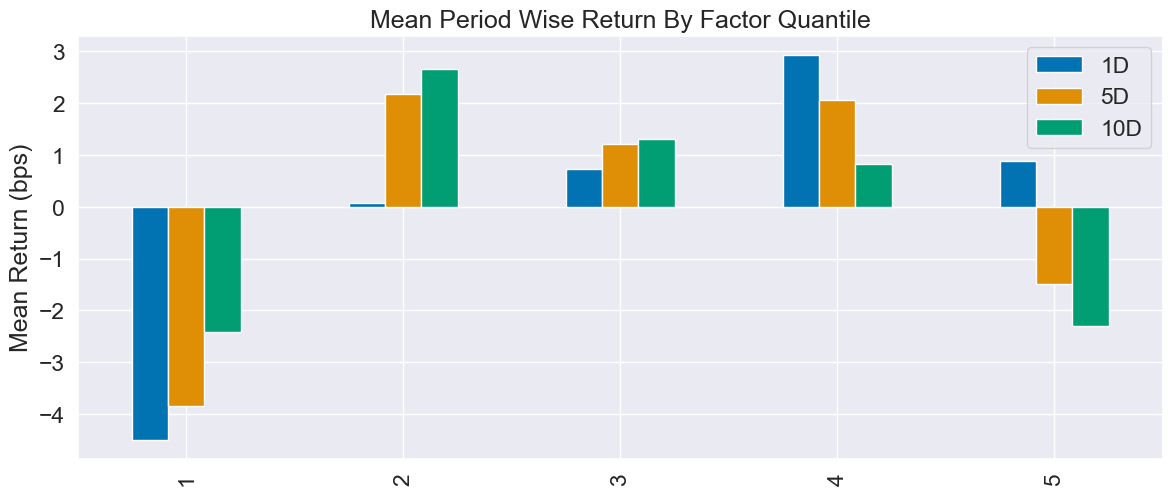

In [477]:
# Run analysis
alphalens.tears.create_summary_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.218,0.106,0.071
beta,0.059,0.067,0.037
Mean Period Wise Return Top Quantile (bps),0.876,-1.499,-2.300
Mean Period Wise Return Bottom Quantile (bps),-4.494,-3.850,-2.425
Mean Period Wise Spread (bps),5.370,2.418,0.113


<Figure size 640x480 with 0 Axes>

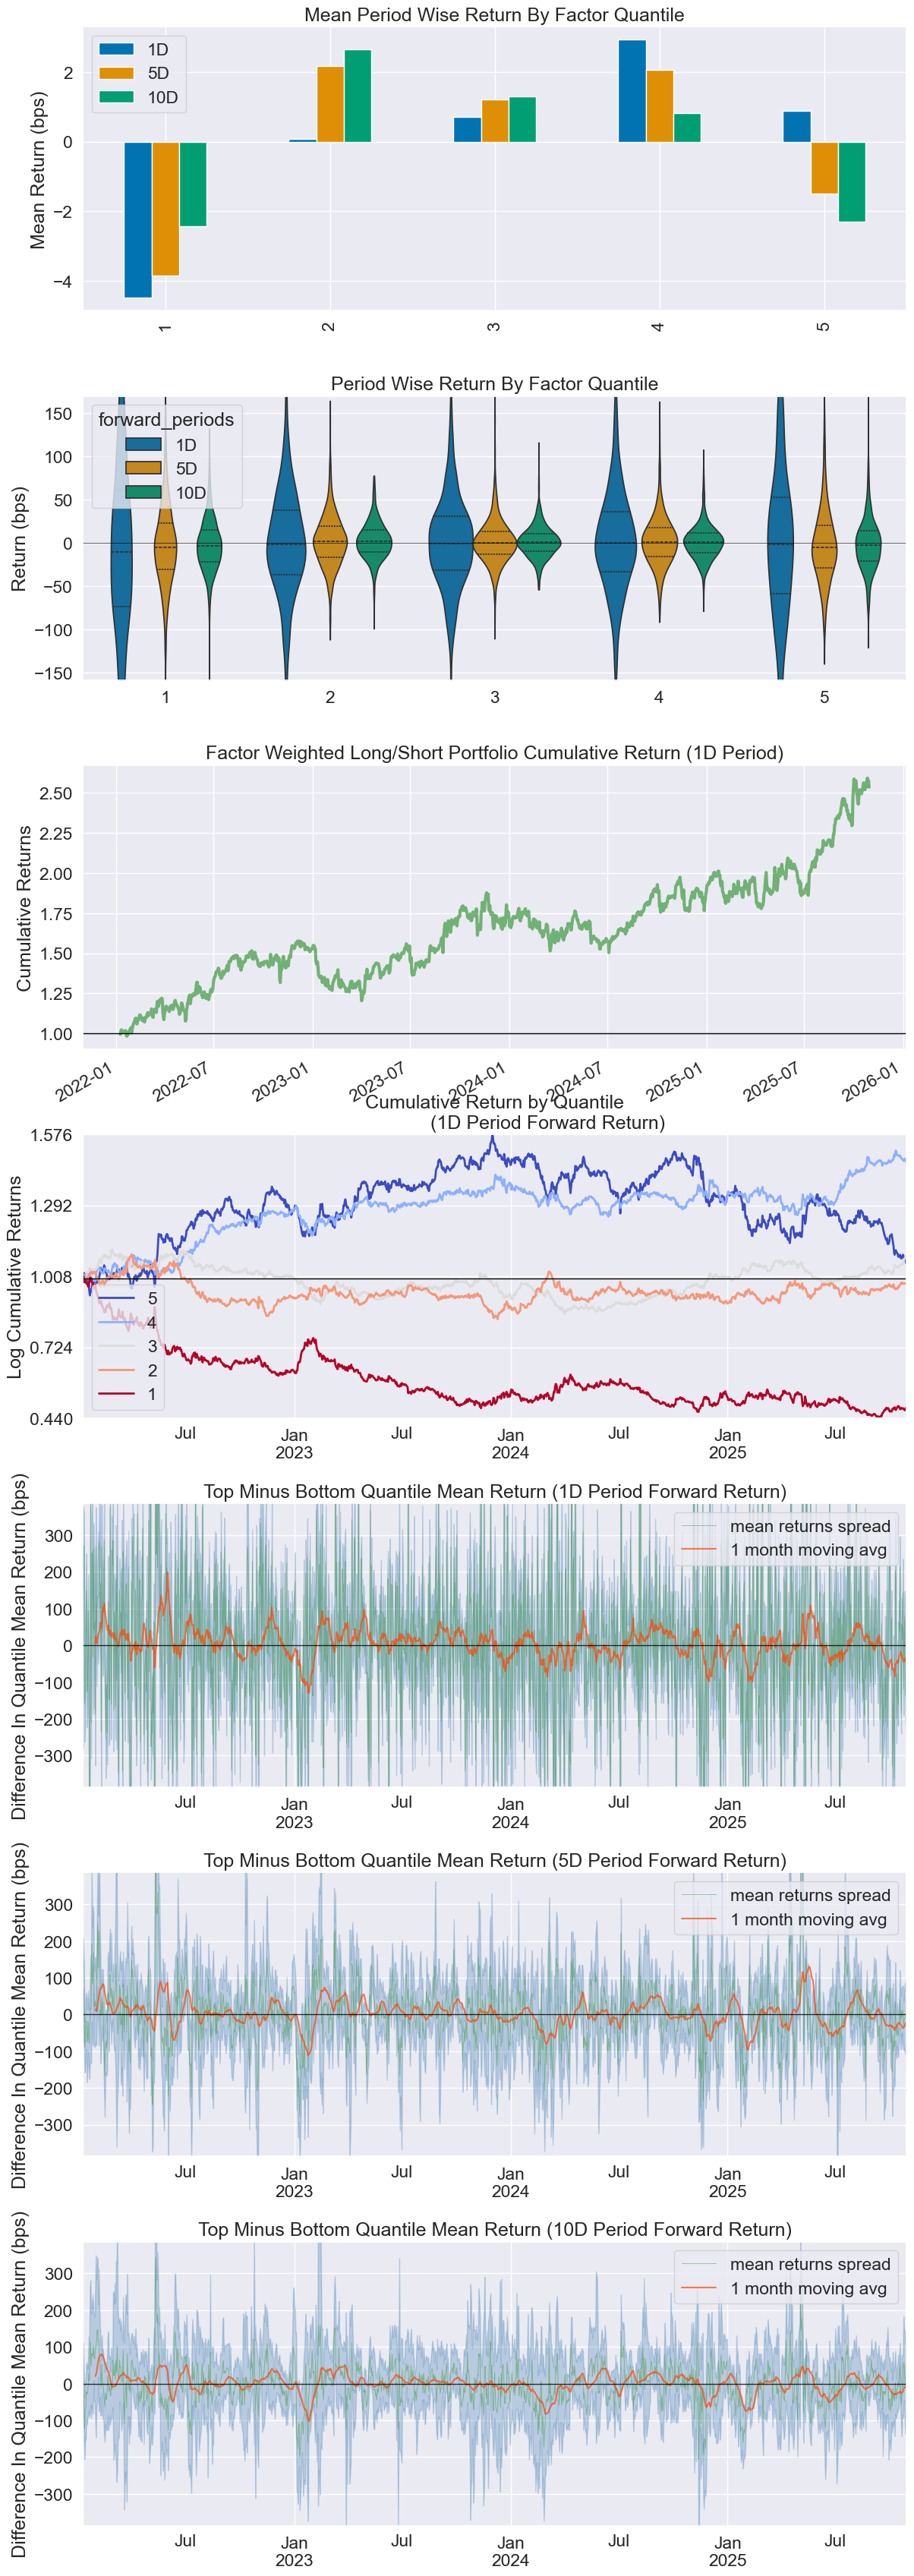

In [478]:
# Run analysis
alphalens.tears.create_returns_tear_sheet(factor_data)

# SPP

<Axes: xlabel='Open time'>

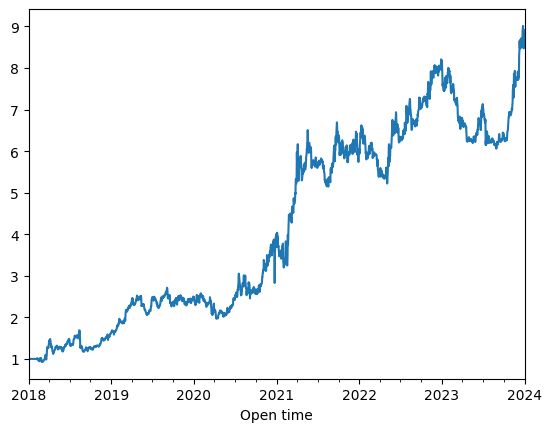

In [65]:
# pfo = get_factor_ls_portfolio(prices, factor, flipped=True, bt_start='2022-01-01', fees=0.000, volume=None, volume_threshold=10_000_000)

# Define the factor

# factor = prices_1d.pct_change(7).shift()

lookbacks = { 
    26: 0.1,
    27: 0.1,
    28: 0.1, 
    29: 0.1, 
    30: 0.1, 
    31: 0.1, 
    32: 0.1,
    33: 0.1,
    34: 0.1,
    35: 0.1
}

# lookbacks = { 
#     20: 0.2,
#     25: 0.2,
#     30: 0.2, 
#     35: 0.2, 
#     40: 0.2
# }


prices = price.copy()

factors = []
for lb, weight in lookbacks.items():
    f = price.pct_change(lb) * weight
    factors.append(f)
factor = sum(factors)


# Align factor and price data
common_index = factor.index.intersection(prices.index)
factor = factor.loc[common_index].copy()
prices = prices.loc[common_index].copy()


pfo, weights, trades = get_factor_ls_portfolio(
                            prices.loc[:'2024-01-01'], 
                            factor.loc[:'2024-01-01'], 
                            flipped=False, 
                            bt_start=None, 
                            bt_end=None, 
                            fees=0.0005, 
                            visualize_legs=False,
                            # volume=volumes_1d.rolling(7).mean().shift(),
                            # volume_threshold=100_000,
                            weight_method="equal",
                            vol_lookback=30,
                            mcap=_mcap,
                            top=20
                        )

pfo.returns().add(1).cumprod().plot()
# prices.BTCUSDT.pct_change().add(1).cumprod().plot()

In [66]:
ep.sharpe_ratio(pfo.returns(), annualization=365)

1.1273404285584037

In [39]:
_price = price.copy()
factor = _price.pct_change(30)
common_index = factor.index.intersection(_price.index)
factor = factor.loc[common_index].copy()
_price = _price.loc[common_index].copy()
_volume = volume.loc[common_index].copy()
_mcap = mcap.loc[common_index].copy()

fitted_pfo, weights, trades = get_factor_ls_portfolio(
    _price.loc[:'2024-01-01'], 
    factor.loc[:'2024-01-01'], 
    flipped=False, 
    bt_start=None, 
    bt_end=None, 
    fees=0.0005, 
    visualize_legs=False,
    volume=None,
    volume_threshold=None,
    weight_method="equal",
    vol_lookback=None,
    mcap=_mcap,
    top=20
)


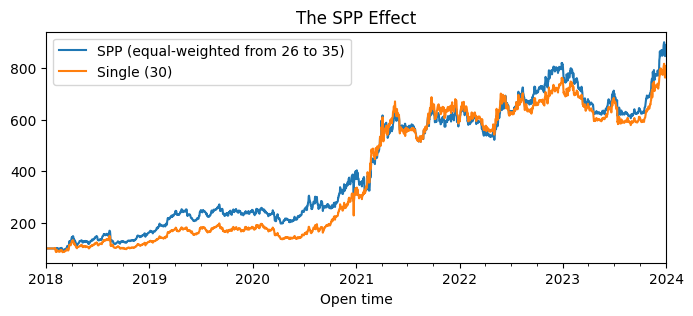

In [67]:
plt.figure(figsize=(8, 3))  
pfo.value().plot(label='SPP (equal-weighted from 26 to 35)')
fitted_pfo.value().plot(label='Single (30)')
plt.title('The SPP Effect')
plt.legend()

# Weight Methods

100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


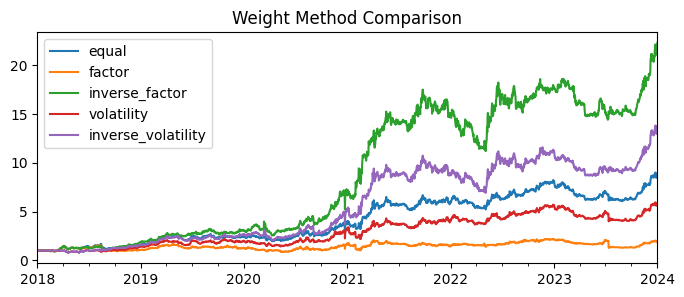

In [42]:
lookbacks = { 
    26: 0.1,
    27: 0.1,
    28: 0.1, 
    29: 0.1, 
    30: 0.1, 
    31: 0.1, 
    32: 0.1,
    33: 0.1,
    34: 0.1,
    35: 0.1
}

# Align factor and price data
prices = price.copy()

factors = []
for lb, weight in lookbacks.items():
    f = prices.pct_change(lb) * weight
    factors.append(f)
factor = sum(factors)

common_index = factor.index.intersection(prices.index)
factor = factor.loc[common_index].copy()
prices = prices.loc[common_index].copy()

weight_methods = [
    'equal',
    'factor',
    'inverse_factor',
    'volatility',
    'inverse_volatility'
]

srs, cagrs, maxdds = [], [], []

plt.figure(figsize=(8, 3))  
for weight_method in tqdm(weight_methods):

    pfo, weights, trades = get_factor_ls_portfolio(
                                prices.loc[:'2024-01-01'], 
                                factor.loc[:'2024-01-01'], 
                                flipped=False, 
                                bt_start=None, 
                                bt_end=None, 
                                fees=0.0005, 
                                visualize_legs=False,
                                # volume=volumes_1d.rolling(7).mean().shift(),
                                # volume_threshold=100_000,
                                weight_method=weight_method,
                                vol_lookback=90,
                                mcap=_mcap,
                                top=20
                            )

    pfo.returns().add(1).cumprod().plot(label=weight_method)

    srs.append(ep.sharpe_ratio(pfo.returns(), annualization=365))
    cagrs.append(ep.cagr(pfo.returns(), annualization=365))
    maxdds.append(ep.max_drawdown(pfo.returns()))

plt.title('Weight Method Comparison')
plt.xlabel('')
plt.legend()
plt.show()

In [43]:
stats = pd.DataFrame(columns=weight_methods, data=[srs, cagrs, maxdds]).T
stats.columns = ['Sharpe', 'CAGR [%]', 'MaxDD [%]']
stats['CAGR [%]'] = stats['CAGR [%]'].mul(100).round(2)
stats['MaxDD [%]'] = stats['MaxDD [%]'].mul(100).round(2)
stats.Sharpe = stats.Sharpe.round(2)
stats.reset_index().rename(columns={"index": "Weight Method"})

,Weight Method,Sharpe,CAGR [%],MaxDD [%]
0,equal,1.13,43.93,-30.72
1,factor,0.49,12.13,-48.57
2,inverse_factor,1.39,67.72,-36.03
3,volatility,0.92,34.23,-35.63
4,inverse_volatility,1.22,54.78,-35.59


In [44]:
ep.sharpe_ratio(pfo.returns(), annualization=365)
# ep.sharpe_ratio(prices.BTCUSDT.pct_change(), annualization=365)
ep.alpha_beta(pfo.returns(), prices.BTCUSDT.pct_change().fillna(0))[1]

-0.029995505710125166

# Out-sample Test & Risk Exposures

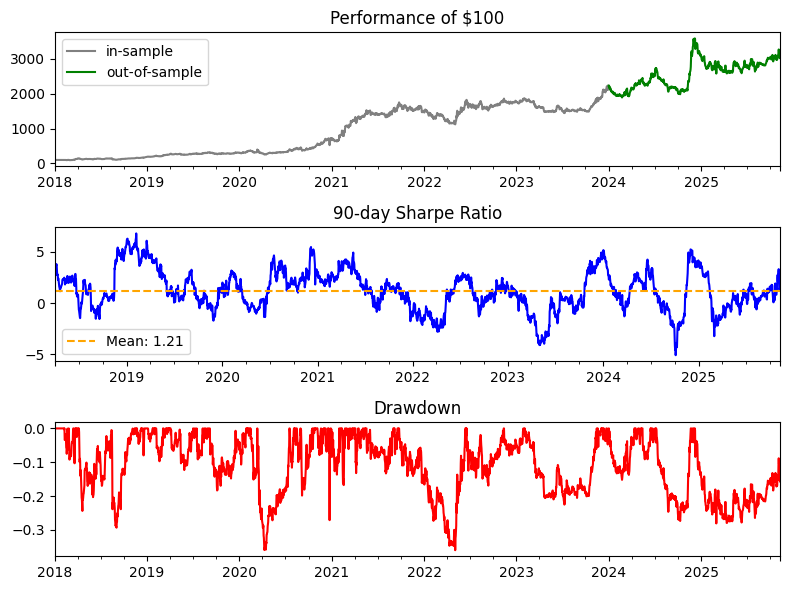

,CAGR,Sharpe,MaxDD
0,54.28,1.24,-36.03


In [68]:
pfo, weights, trades = get_factor_ls_portfolio(
    prices.loc[:],
    factor.loc[:],
    flipped=False,
    bt_start=None,
    bt_end=None,
    fees=0.0005,
    visualize_legs=False,
    # volume=volumes_1d.rolling(7).mean().shift(),
    # volume_threshold=100_000,
    weight_method='inverse_factor',
    # vol_lookback=90,
    mcap=_mcap,
    top=20
)

cumret = pfo.returns().add(1).cumprod().mul(100)
cutoff = pd.Timestamp('2024-01-01', tz=cumret.index.tz if hasattr(cumret.index, "tz") else None)
pre = cumret.loc[:cutoff]
post = cumret.loc[cutoff:]
roll_sharpe = ep.roll_sharpe_ratio(pfo.returns(), annualization=365, window=90)
drawdown = pfo.drawdown()

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=False)

# Plot performance
ax0 = axes[0]
pre.plot(ax=ax0, label="in-sample", color="gray")
if not post.empty:
    post.plot(ax=ax0, label="out-of-sample", color="green")
ax0.set_xlabel("")
ax0.legend()
ax0.set_title('Performance of $100')

# Plot rolling Sharpe
ax1 = axes[1]
roll_sharpe.plot(ax=ax1, color="blue")
mean_sharpe = roll_sharpe.mean()
ax1.axhline(mean_sharpe, linestyle='--', color='orange', label=f'Mean: {mean_sharpe:.2f}')
ax1.legend()
ax1.set_title('90-day Sharpe Ratio')
ax1.set_xlabel("")

# Plot drawdown
ax2 = axes[2]
drawdown.plot(ax=ax2, color="red")
ax2.set_title('Drawdown')
ax2.set_xlabel("")
plt.tight_layout()
plt.show()


# STATS

# cutoff = pd.Timestamp('2024-01-01', tz=pfo.returns().index.tz if hasattr(pfo.returns().index, "tz") else None)
# rets = pfo.returns()

# pre_rets = rets.loc[:cutoff]
# post_rets = rets.loc[cutoff:]

# stats = {}
# for period, r in [('In-sample', pre_rets), ('Out-of-sample', post_rets)]:
#     stats[period] = {
#         'CAGR': round(ep.cagr(r, annualization=365)*100, 2),
#         'Sharpe': round(ep.sharpe_ratio(r, annualization=365), 2),
#         'MaxDD': round(ep.max_drawdown(r)*100, 2)
#     }

# stats_df = pd.DataFrame(stats)
# stats_df

pd.DataFrame({
        'CAGR': round(ep.cagr(pfo.returns(), annualization=365)*100, 2),
        'Sharpe': round(ep.sharpe_ratio(pfo.returns(), annualization=365), 2),
        'MaxDD': round(ep.max_drawdown(pfo.returns())*100, 2)
    }, index=[0])

<Axes: ylabel='Frequency'>

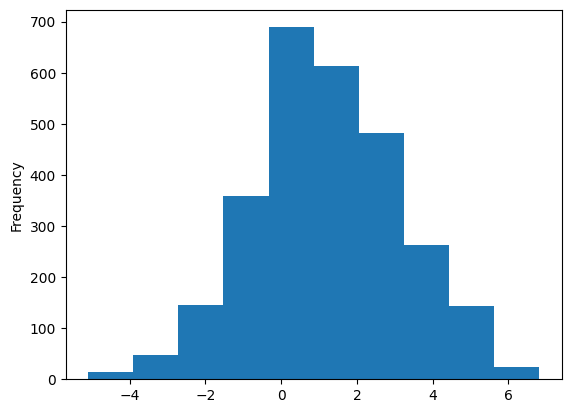

In [69]:
roll_sharpe.plot(kind='hist')

In [1200]:
# mi = pd.read_csv("mi.csv")
# mi.date = pd.to_datetime(mi.date, utc=True)
# mi.set_index('date', inplace=True)
# common_index = pfo.value().index.intersection(mi.index)
# mi = mi.loc[common_index]

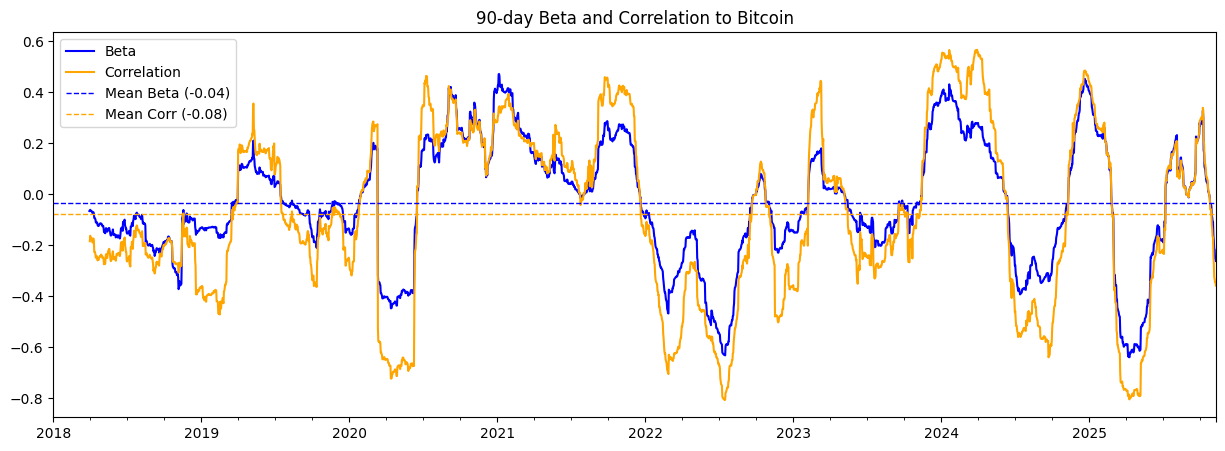

In [46]:
plt.figure(figsize=(15, 5))

roll_beta = ep.roll_beta(pfo.returns(), price.loc[pfo.returns().index]['BTCUSDT'].pct_change(), 90)
roll_corr = pfo.returns().rolling(90).corr(price.loc[pfo.returns().index]['BTCUSDT'].pct_change())

roll_beta.index.name = None
roll_corr.index.name = None

ax = roll_beta.plot(label="Beta", color="blue")
roll_corr.plot(label="Correlation", color="orange", ax=ax)

# Add mean beta and corr as horizontal dashed lines with label
mean_beta = roll_beta.mean()
mean_corr = roll_corr.mean()
ax.axhline(mean_beta, color="blue", linestyle="--", linewidth=1, label=f"Mean Beta ({mean_beta:.2f})")
ax.axhline(mean_corr, color="orange", linestyle="--", linewidth=1, label=f"Mean Corr ({mean_corr:.2f})")

plt.title("90-day Beta and Correlation to Bitcoin")
plt.legend(loc="upper left")
plt.show()
